# **TEMAS AVANZADOS EN COMPUTACIÓN (INF389)**
## **Tarea académica - Grupo Capybaras Hackers**  
### **Descripción de la tarea**

El objetivo de esta tarea es predecir la raza de perros. El conjunto de datos a utilizar contiene 20 mil fotografías con más de 120 razas de perros diferentes.

Integrantes:

- Paolo Galliquio
- Renzo Richle
- Claudio Lozano
- César Rafael

**Dataset (Fuente):** https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

In [ ]:
#@title imports.py
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3


import tensorflow_hub as hub

In [ ]:
filelist  = []

for dirname, _, filenames in os.walk('./images/Images/'):
    for filename in filenames:
        filelist.append(os.path.join(dirname, filename))

In [ ]:
len(filelist)

16050

In [ ]:
Filepaths   = []
labels = []
for image_file in filelist:
    label = image_file.split(os.path.sep)[-2].split('-')[1]

    Filepaths.append(image_file)
    labels.append(label)

In [ ]:
len(Filepaths), len(labels)

(16050, 16050)

In [ ]:
Filepaths[:5], labels[:5]

(['./images/Images/n02085620-Chihuahua\\n02085620_10074.jpg',
  './images/Images/n02085620-Chihuahua\\n02085620_10131.jpg',
  './images/Images/n02085620-Chihuahua\\n02085620_10621.jpg',
  './images/Images/n02085620-Chihuahua\\n02085620_1073.jpg',
  './images/Images/n02085620-Chihuahua\\n02085620_10976.jpg'],
 ['Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua'])

In [ ]:
len(set(labels))

95

In [ ]:
df = pd.DataFrame(list(zip(Filepaths, labels)), columns = ['Filepath', 'Labels'] )
df = (df.sample(frac = 1, random_state=42).reset_index()).drop(columns = 'index')
df.head()

,Filepath,Labels
0,./images/Images/n02100236-German_short-haired_...,German_short
1,./images/Images/n02104029-kuvasz\n02104029_132...,kuvasz
2,./images/Images/n02104365-schipperke\n02104365...,schipperke
3,./images/Images/n02092339-Weimaraner\n02092339...,Weimaraner
4,./images/Images/n02093428-American_Staffordshi...,American_Staffordshire_terrier


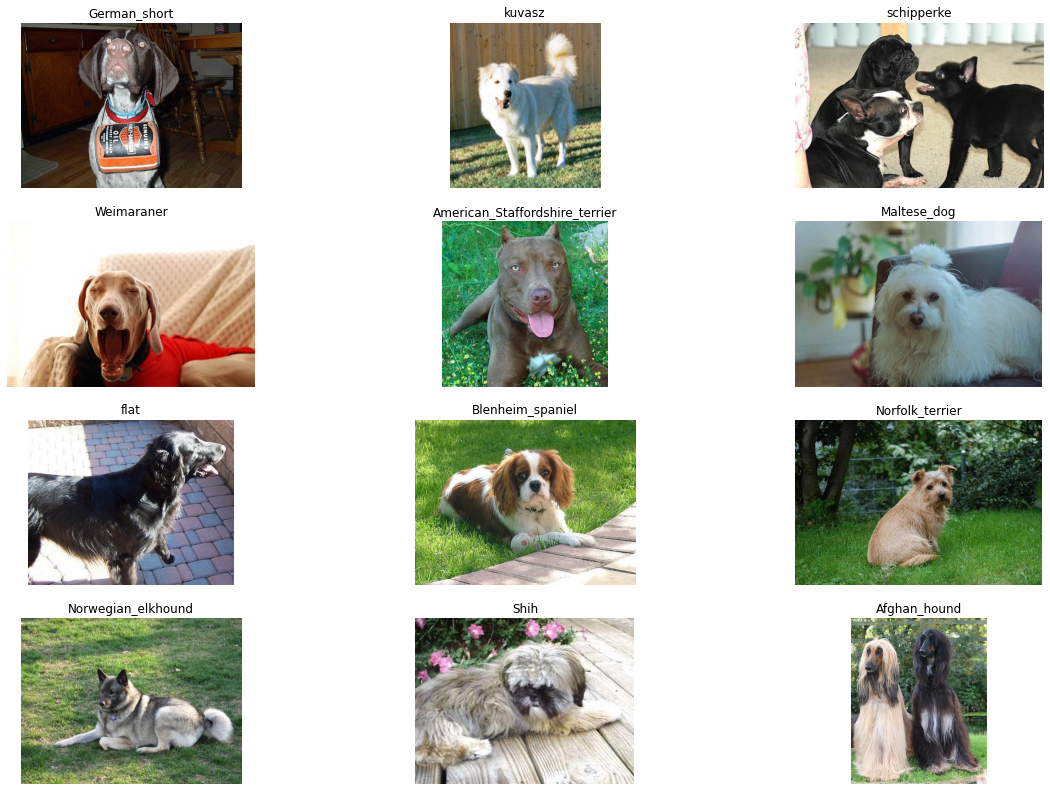

In [ ]:
fig, axis = plt.subplots(4, 3,figsize=(20, 14))

for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])
    ax.axis('off')
    
plt.show()

In [ ]:
pd.value_counts(df['Labels'],ascending=False).tail(10)

groenendael         150
Border_collie       150
kuvasz              150
clumber             150
Doberman            150
golden_retriever    150
malinois            150
Pekinese            149
redbone             148
French_bulldog       27
Name: Labels, dtype: int64

In [ ]:
pd.DataFrame(df['Labels'].unique()).to_csv("dog_breeds.csv", index=False, header=False)

In [ ]:
val_ratio = test_ratio = 0.2

train, test = train_test_split(df, test_size=test_ratio, random_state=42)
val, test = train_test_split(test, test_size=val_ratio, random_state=42)
len(train), len(val), len(test)

(12840, 2568, 642)

In [ ]:
img_datagen = ImageDataGenerator(rescale=1./255, 
                                 rotation_range=30, 
                                 width_shift_range=0.2,
                                 height_shift_range=0.2, 
                                 horizontal_flip = 'true')

In [ ]:
train_generator=img_datagen.flow_from_dataframe(dataframe=train,
                                                x_col="Filepath",
                                                y_col="Labels",
                                                batch_size=32,
                                                seed=42,
                                                shuffle=True,
                                                target_size=(299, 299))

Found 12840 validated image filenames belonging to 95 classes.


In [ ]:
val_generator=img_datagen.flow_from_dataframe(dataframe=val,
                                              x_col="Filepath",
                                              y_col="Labels",
                                              batch_size=32,
                                              seed=42,
                                              shuffle=True,
                                              target_size=(299, 299))

test_generator=img_datagen.flow_from_dataframe(dataframe=test,
                                               x_col="Filepath",
                                               y_col="Labels",
                                               batch_size=32,
                                               seed=42,
                                               shuffle=True,
                                               target_size=(299, 299))

Found 2568 validated image filenames belonging to 95 classes.
Found 642 validated image filenames belonging to 93 classes.


In [ ]:
i_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(299, 299, 3))

In [ ]:
for layer in i_model.layers:
    layer.trainable = False
    
i_model.summary() 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
model = Sequential()
model.add(i_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(95, activation = 'softmax'))

model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 95)                12255     
                                                                 
Total params: 22,077,311
Trainable params: 274,527
Non-trainable params: 21,802,784
______________________________________

In [ ]:
model.compile(optimizer = Adam(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=cb_early_stopper,
                    epochs=10)

Epoch 1/10
401/401 [==============================] - 635s 2s/step - loss: 0.6636 - accuracy: 0.8066 - val_loss: 0.6723 - val_accuracy: 0.8074
Epoch 2/10
401/401 [==============================] - 682s 2s/step - loss: 0.5954 - accuracy: 0.8235 - val_loss: 0.5916 - val_accuracy: 0.8230
Epoch 3/10
401/401 [==============================] - 626s 2s/step - loss: 0.5472 - accuracy: 0.8365 - val_loss: 0.6437 - val_accuracy: 0.8180
Epoch 4/10
401/401 [==============================] - 660s 2s/step - loss: 0.5566 - accuracy: 0.8317 - val_loss: 0.6458 - val_accuracy: 0.8168
Epoch 5/10
401/401 [==============================] - 574s 1s/step - loss: 0.5187 - accuracy: 0.8456 - val_loss: 0.6831 - val_accuracy: 0.8211
Epoch 6/10
401/401 [==============================] - 640s 2s/step - loss: 0.4774 - accuracy: 0.8520 - val_loss: 0.6125 - val_accuracy: 0.8387
Epoch 7/10
401/401 [==============================] - 643s 2s/step - loss: 0.4680 - accuracy: 0.8564 - val_loss: 0.6393 - val_accuracy: 0.8297

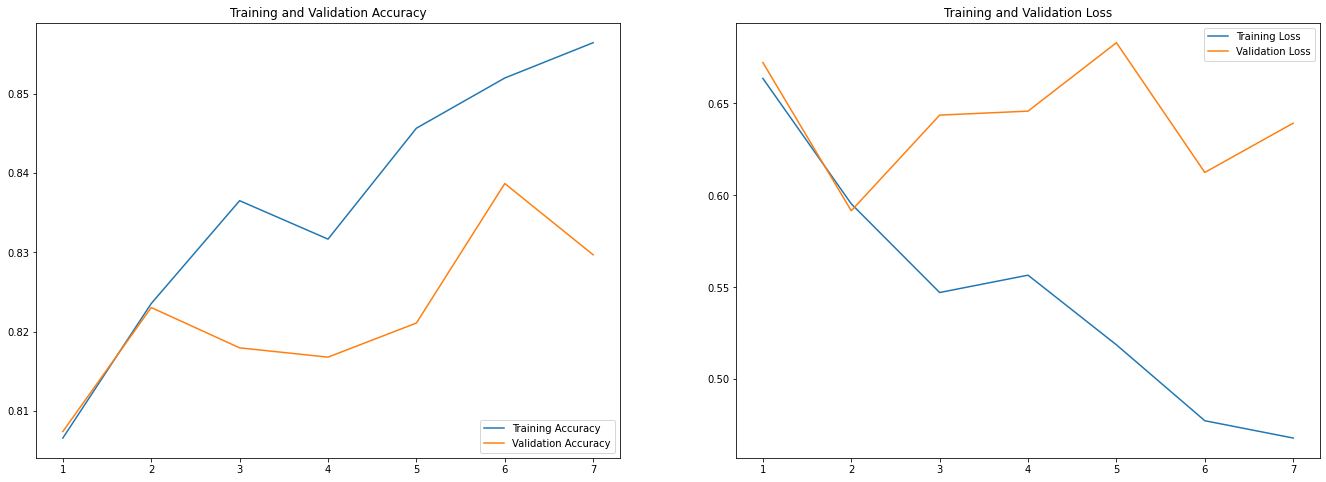

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()